In [1]:
# 필요한 라이브러리 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from data_loader import load_from_gsheet

In [2]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'   # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 깨짐 방지

In [3]:
# MAPE 계산 함수
def calculate_mape(y_true, y_pred):
    """
    MAPE (Mean Absolute Percentage Error) 계산
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    nonzero_idx = y_true != 0
    
    
    if not np.any(nonzero_idx):
        return np.inf
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [4]:
# 지수 가중치 함수
def create_exponential_weights(n_samples, decay_rate=0.1):
    """
    최근 데이터에 더 높은 가중치를 주는 지수 가중치 생성
    decay_rate: 가중치 감소 비율 (클수록 최근 데이터에 더 높은 가중치)
    """
    weights = np.exp(-decay_rate * np.arange(n_samples-1, -1, -1))
    return weights / weights.sum() * n_samples  # 평균이 1이 되도록 정규화


In [5]:
# 모델 딕셔너리 정의
def get_models():
    """
    사용할 머신러닝 모델들 정의
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, verbosity=0),
        'LightGBM': LGBMRegressor(random_state=42, verbosity=-1),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5),
        'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    }
    return models


In [6]:
def load_and_prepare_data(file_path):
    """
    데이터 로드 및 시간 맞추기
    """
    df = pd.read_csv(file_path)
    
    # 판매일을 datetime으로 변환
    df['판매일'] = pd.to_datetime(df['판매일'])
    
    # 데이터를 판매일 순으로 정렬
    df = df.sort_values('판매일')
    
    print(f"전체 데이터 크기: {df.shape}")
    print(f"메뉴 종류: {df['상품명'].nunique()}개")
    print(f"데이터 기간: {df['판매일'].min()} ~ {df['판매일'].max()}")
    
    return df

In [7]:
# 메뉴별 모델 학습 및 평가
def train_and_evaluate_models(df, target_col='일별수량'):
    """
    메뉴별로 모든 모델을 학습하고 평가
    """
    results = {}
    menu_models = {}
    
    # 피처 컬럼 정의 (일별수량과 판매일, 상품명 제외) ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    feature_cols = ['요일_cos']
    # ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    print(f"사용할 피처: {feature_cols}")
    
    # 각 메뉴별로 처리
    for menu in df['상품명'].unique():
        print(f"\n=== {menu} 모델 학습 중 ===")
        
        # 메뉴별 데이터 필터링
        menu_data = df[df['상품명'] == menu].copy()
        menu_data = menu_data.sort_values('판매일')
        
        if len(menu_data) < 10:  # 데이터가 너무 적으면 스킵
            print(f"{menu}: 데이터가 부족합니다 ({len(menu_data)}개)")
            continue
        
        # 마지막 하루를 테스트 데이터로 분리
        train_data = menu_data.iloc[:-1]
        test_data = menu_data.iloc[-1:]
        
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        X_test = test_data[feature_cols]
        y_test = test_data[target_col]
        
        # 지수 가중치 생성
        sample_weights = create_exponential_weights(len(X_train))
        
        # 피처 스케일링
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 각 모델 학습 및 평가
        menu_results = {}
        models = get_models()
        
        for model_name, model in models.items():
            try:
                # 가중치를 지원하는 모델인지 확인
                if hasattr(model, 'fit') and 'sample_weight' in model.fit.__code__.co_varnames:
                    if model_name in ['SVR', 'MLP']:
                        # SVR과 MLP는 스케일된 데이터 사용
                        model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
                        y_pred = model.predict(X_test_scaled)
                    else:
                        model.fit(X_train, y_train, sample_weight=sample_weights)
                        y_pred = model.predict(X_test)
                else:
                    # 가중치를 지원하지 않는 모델
                    if model_name in ['SVR', 'MLP']:
                        model.fit(X_train_scaled, y_train)
                        y_pred = model.predict(X_test_scaled)
                    else:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                
                # 메트릭 계산
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mape = calculate_mape(y_test.values, y_pred)
                
                menu_results[model_name] = {
                    'RMSE': rmse,
                    'MAPE': mape,
                    'y_true': y_test.values[0],
                    'y_pred': y_pred[0],
                    'model': model,
                    'scaler': scaler if model_name in ['SVR', 'MLP'] else None
                }
                
                print(f"  {model_name}: RMSE={rmse:.4f}, MAPE={mape:.2f}%")
                
            except Exception as e:
                print(f"  {model_name}: 학습 실패 - {e}")
                continue
        
        # 베이스 모델 선정 (MASE 기준)
        if menu_results:
            best_model = min(menu_results.keys(), key=lambda x: menu_results[x]['MAPE'])
            menu_results['best_model'] = best_model
            print(f"  베이스 모델: {best_model}")
            
            results[menu] = menu_results
            menu_models[menu] = menu_results[best_model]
    
    return results, menu_models


In [8]:
# 결과 시각화
def visualize_results(results):
    """
    메뉴별 모델 성능 및 예측 결과 시각화
    """
    n_menus = len(results)
    if n_menus == 0:
        print("시각화할 결과가 없습니다.")
        return
    
    # 각 메뉴별로 개별 시각화
    for i, (menu, menu_results) in enumerate(results.items()):
        if 'best_model' not in menu_results:
            continue
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{menu} - 모델 성능 분석', fontsize=16, fontweight='bold')
        
        # 1. RMSE 비교
        models = [k for k in menu_results.keys() if k != 'best_model']
        rmse_values = [menu_results[k]['RMSE'] for k in models]
        
        bars1 = ax1.bar(range(len(models)), rmse_values, color='skyblue', alpha=0.7)
        ax1.set_xlabel('모델')
        ax1.set_ylabel('RMSE')
        ax1.set_title('RMSE 비교')
        ax1.set_xticks(range(len(models)))
        ax1.set_xticklabels(models, rotation=45, ha='right')
        
        # 베이스 모델 하이라이트
        best_idx = models.index(menu_results['best_model'])
        bars1[best_idx].set_color('orange')
        
        # 2. MAPE 비교
        mape_values = [menu_results[k]['MAPE'] for k in models]
        bars2 = ax2.bar(range(len(models)), mape_values, color='lightgreen', alpha=0.7)
        ax2.set_xlabel('모델')
        ax2.set_ylabel('MAPE (%)')
        ax2.set_title('MAPE 비교')
        ax2.set_xticks(range(len(models)))
        ax2.set_xticklabels(models, rotation=45, ha='right')
        
        # 베이스 모델 하이라이트
        bars2[best_idx].set_color('red')
        
        # 3. 예측 vs 실제값 비교
        y_true_values = [menu_results[k]['y_true'] for k in models]
        y_pred_values = [menu_results[k]['y_pred'] for k in models]
        
        x_pos = np.arange(len(models))
        width = 0.35
        
        ax3.bar(x_pos - width/2, y_true_values, width, label='실제값', color='blue', alpha=0.7)
        ax3.bar(x_pos + width/2, y_pred_values, width, label='예측값', color='red', alpha=0.7)
        ax3.set_xlabel('모델')
        ax3.set_ylabel('일별수량')
        ax3.set_title('실제값 vs 예측값')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(models, rotation=45, ha='right')
        ax3.legend()
        
        # 4. 베이스 모델 상세 정보
        best_model_name = menu_results['best_model']
        best_results = menu_results[best_model_name]
        
        ax4.text(0.1, 0.8, f'베이스 모델: {best_model_name}', fontsize=14, fontweight='bold')
        ax4.text(0.1, 0.6, f'RMSE: {best_results["RMSE"]:.4f}', fontsize=12)
        ax4.text(0.1, 0.4, f'MAPE: {best_results["MAPE"]:.2f}%', fontsize=12)
        ax4.text(0.1, 0.2, f'실제값: {best_results["y_true"]:.2f}', fontsize=12)
        ax4.text(0.1, 0.0, f'예측값: {best_results["y_pred"]:.2f}', fontsize=12)
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')
        
        plt.tight_layout()
        plt.show()

In [9]:
# 전체 성능 요약
def summary_results(results):
    """
    전체 결과 요약
    """
    if not results:
        print("분석할 결과가 없습니다.")
        return
    
    print("\n" + "="*80)
    print("전체 결과 요약")
    print("="*80)
    
    summary_data = []
    for menu, menu_results in results.items():
        if 'best_model' not in menu_results:
            continue
            
        best_model_name = menu_results['best_model']
        best_results = menu_results[best_model_name]
        
        summary_data.append({
            '메뉴': menu,
            '베이스_모델': best_model_name,
            'RMSE': best_results['RMSE'],
            'MAPE(%)': best_results['MAPE'],
            '실제값': best_results['y_true'],
            '예측값': best_results['y_pred'],
            '오차율(%)': abs(best_results['y_true'] - best_results['y_pred']) / best_results['y_true'] * 100
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.round(4)
    
    print(summary_df.to_string(index=False))
    
    # 전체 평균 성능
    print(f"\n평균 RMSE: {summary_df['RMSE'].mean():.4f}")
    print(f"평균 MAPE: {summary_df['MAPE(%)'].mean():.2f}%")
    print(f"평균 오차율: {summary_df['오차율(%)'].mean():.2f}%")
    
    # 모델별 선택 빈도
    model_counts = summary_df['베이스_모델'].value_counts()
    print(f"\n베이스 모델 선택 빈도:")
    for model, count in model_counts.items():
        print(f"  {model}: {count}회")

음식점 매출 예측 베이스 모델 구축을 시작합니다!
사용할 피처: ['요일_cos']

=== 가지치즈솥밥 모델 학습 중 ===
  Linear Regression: RMSE=0.1820, MAPE=inf%
  Ridge: RMSE=0.1820, MAPE=inf%
  Lasso: RMSE=0.1769, MAPE=inf%
  ElasticNet: RMSE=0.1769, MAPE=inf%
  Decision Tree: RMSE=0.1509, MAPE=inf%
  Random Forest: RMSE=0.1497, MAPE=inf%
  Extra Trees: RMSE=0.1509, MAPE=inf%
  Gradient Boosting: RMSE=0.1509, MAPE=inf%
  XGBoost: RMSE=0.1510, MAPE=inf%
  LightGBM: RMSE=0.0568, MAPE=inf%
  SVR: RMSE=0.1000, MAPE=inf%
  KNN: RMSE=0.0000, MAPE=inf%
  MLP: RMSE=0.1460, MAPE=inf%
  베이스 모델: Linear Regression

=== 우삼겹스키야키 모델 학습 중 ===
  Linear Regression: RMSE=2.5933, MAPE=inf%
  Ridge: RMSE=2.5928, MAPE=inf%
  Lasso: RMSE=2.4933, MAPE=inf%
  ElasticNet: RMSE=2.4933, MAPE=inf%
  Decision Tree: RMSE=2.5849, MAPE=inf%
  Random Forest: RMSE=2.5931, MAPE=inf%
  Extra Trees: RMSE=2.5849, MAPE=inf%
  Gradient Boosting: RMSE=2.5849, MAPE=inf%
  XGBoost: RMSE=2.5849, MAPE=inf%
  LightGBM: RMSE=1.6713, MAPE=inf%
  SVR: RMSE=1.8998, MAPE=inf%
  KN

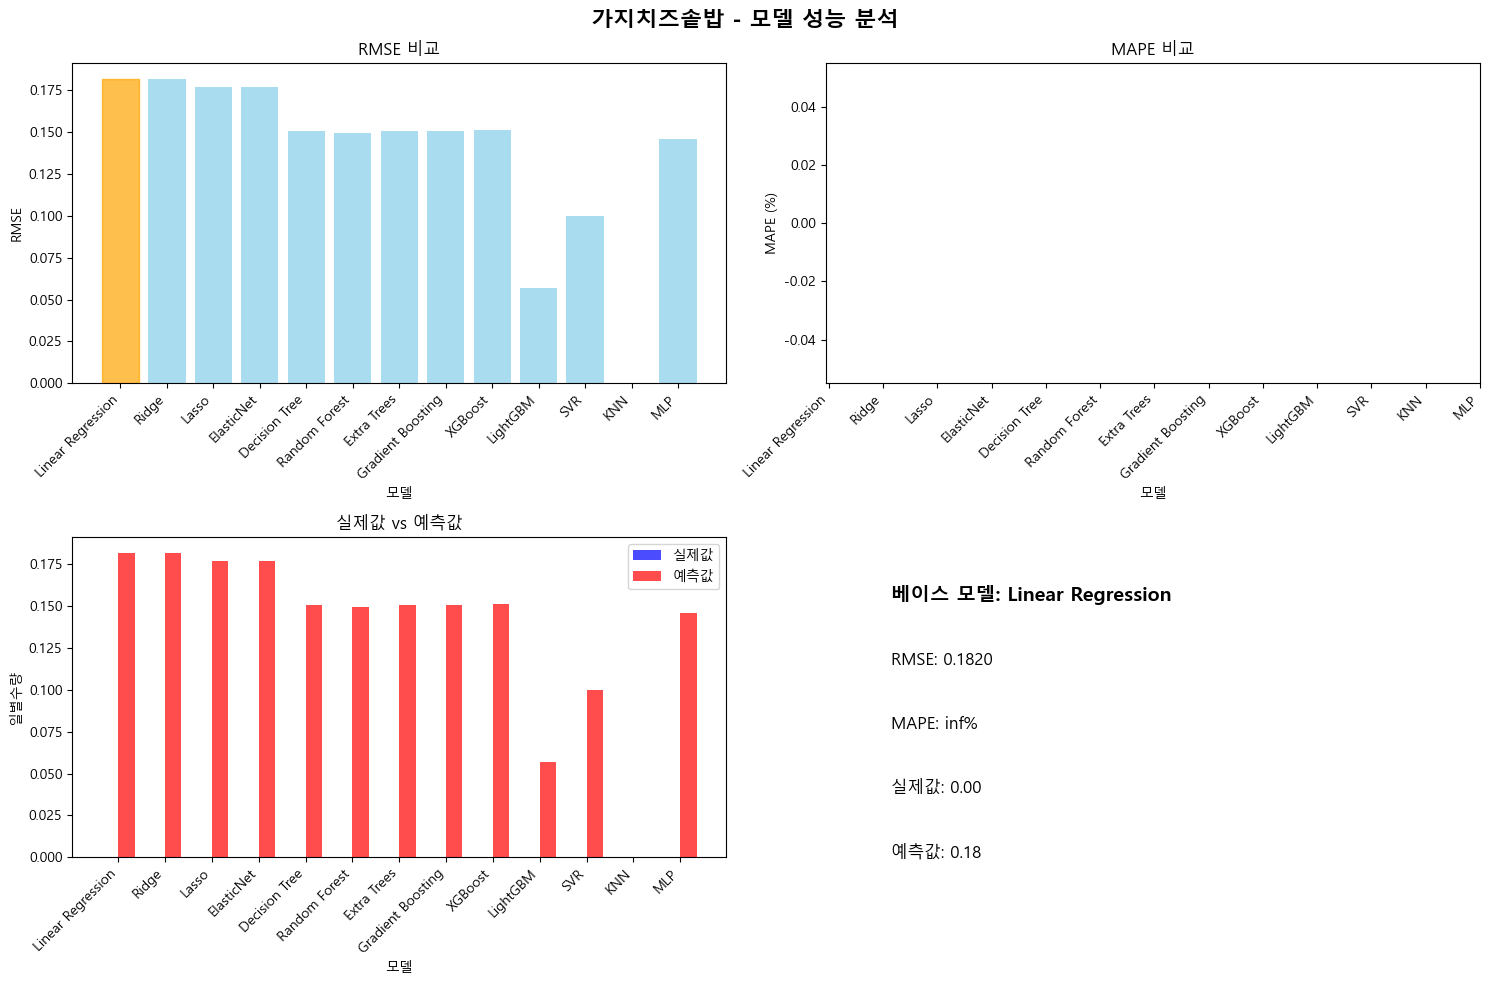

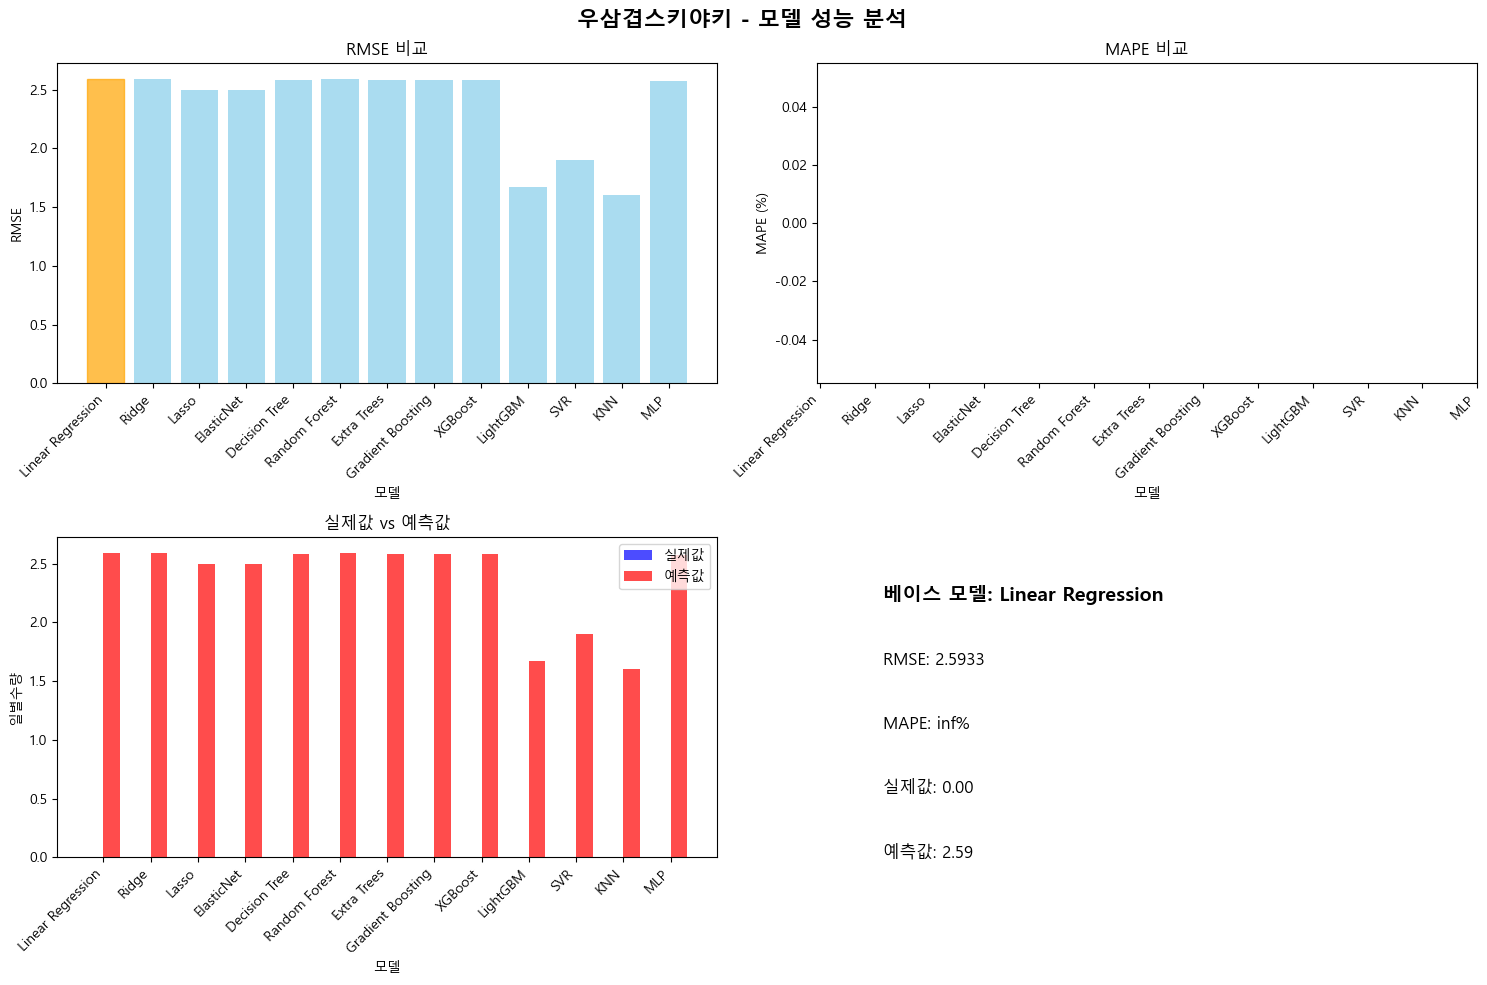

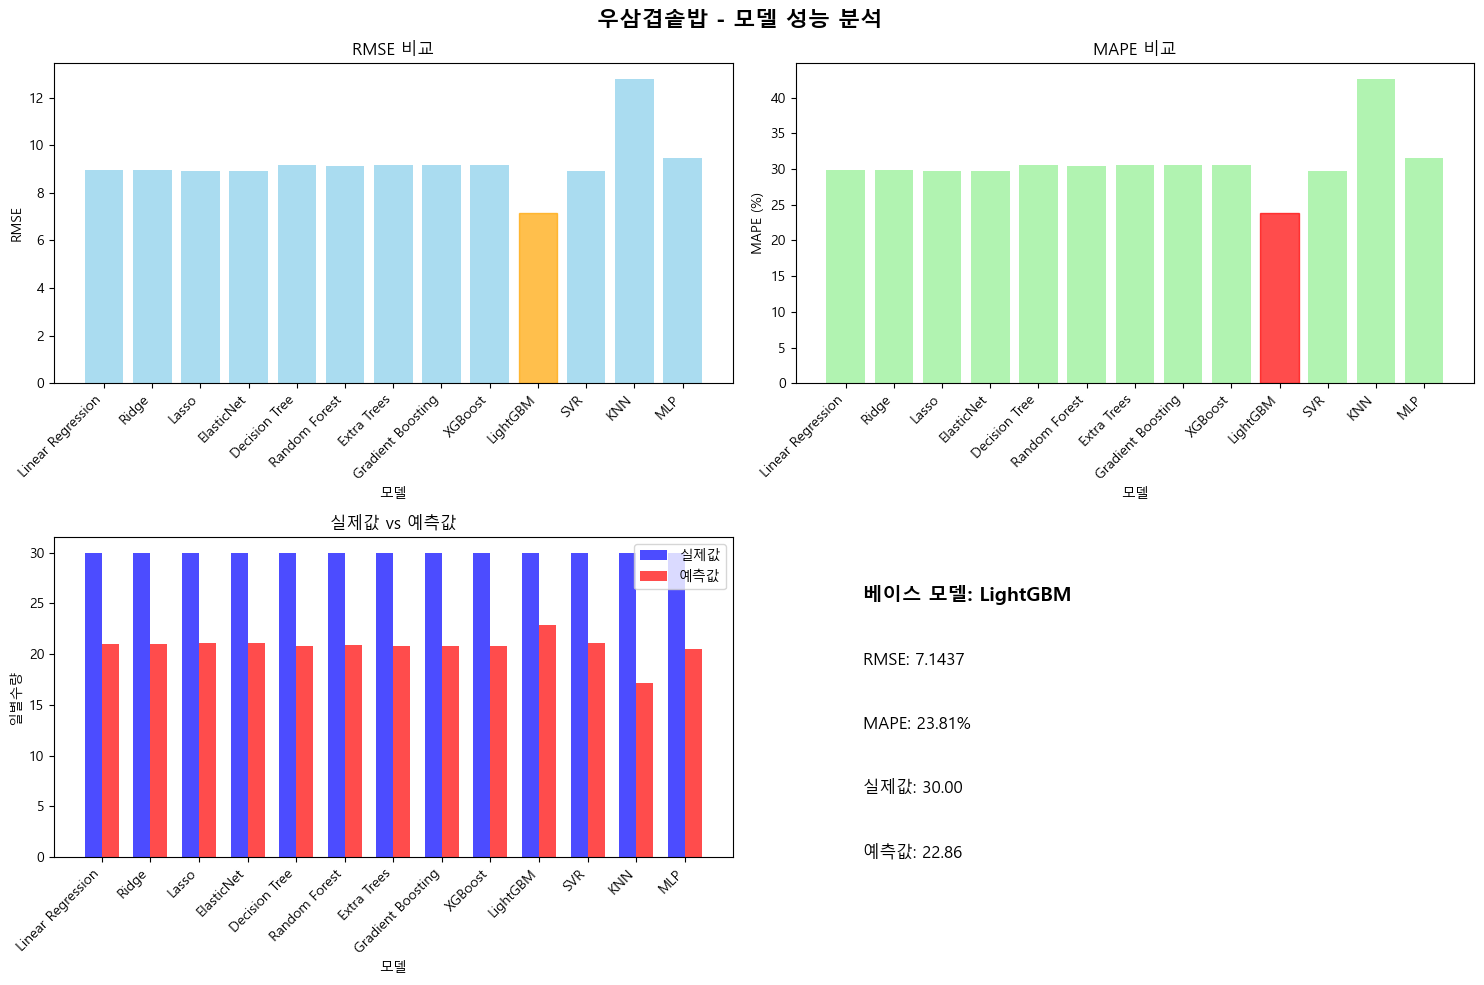

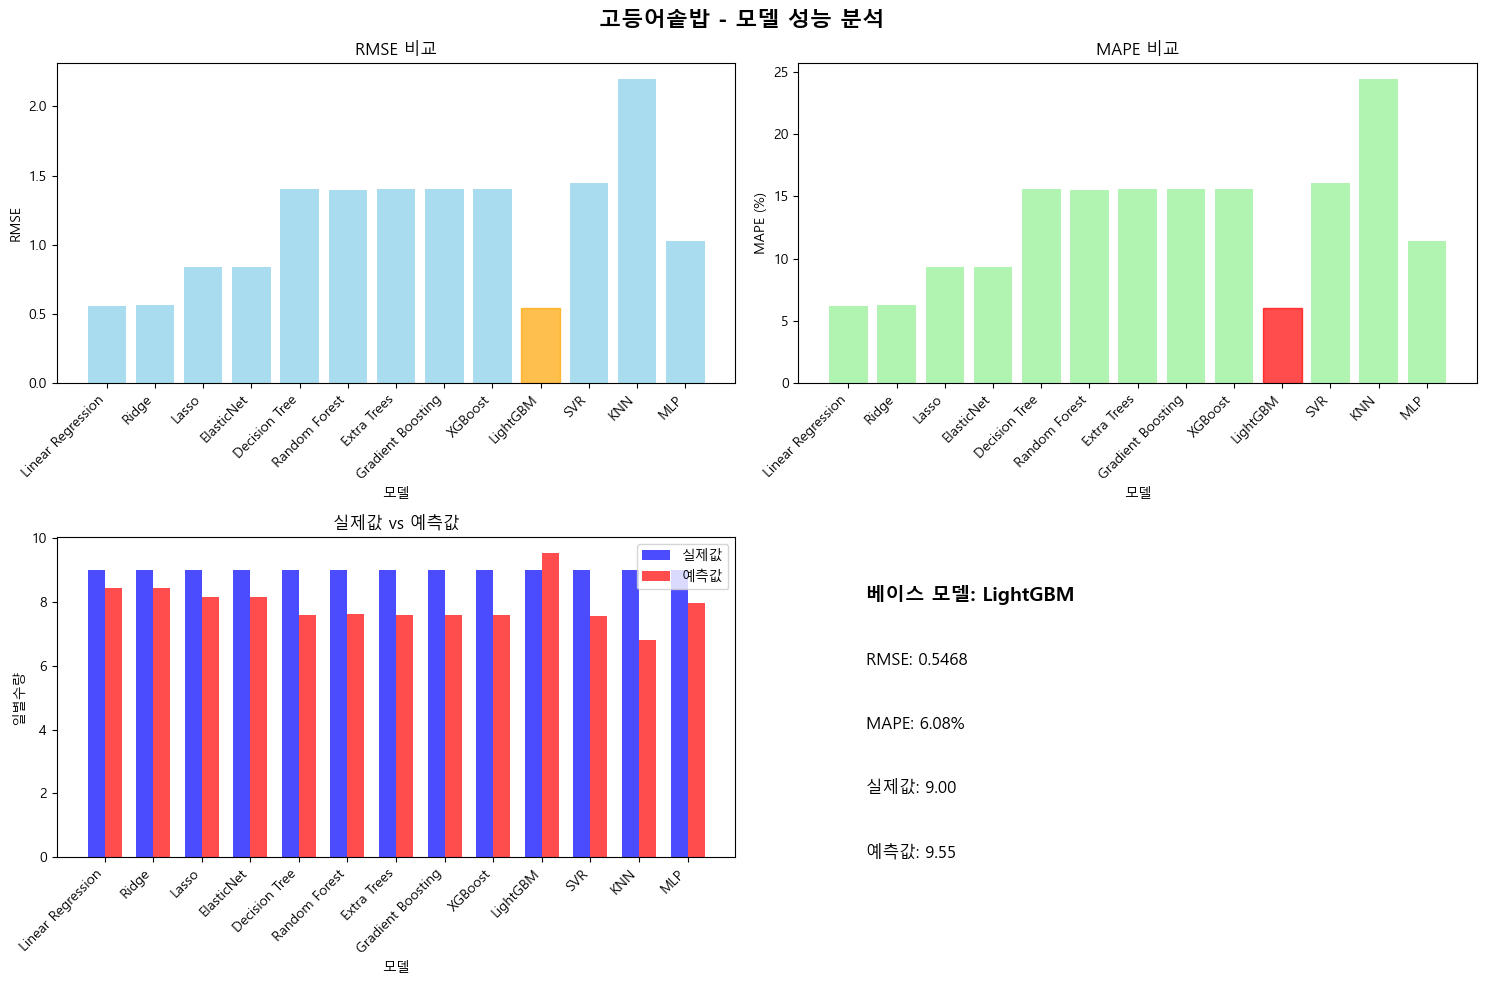

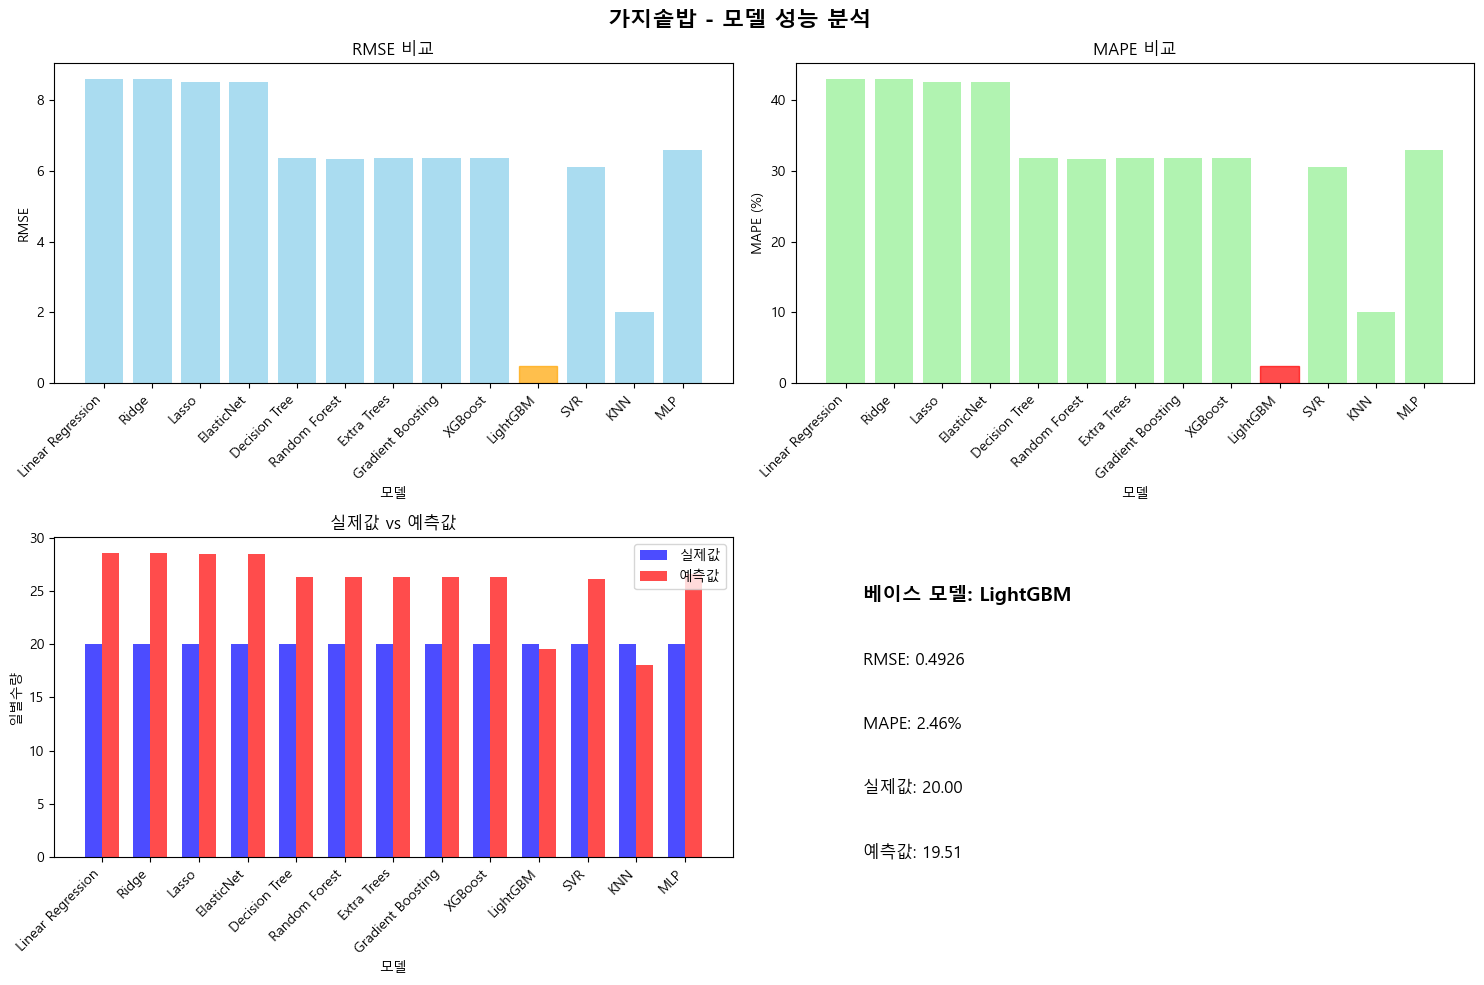

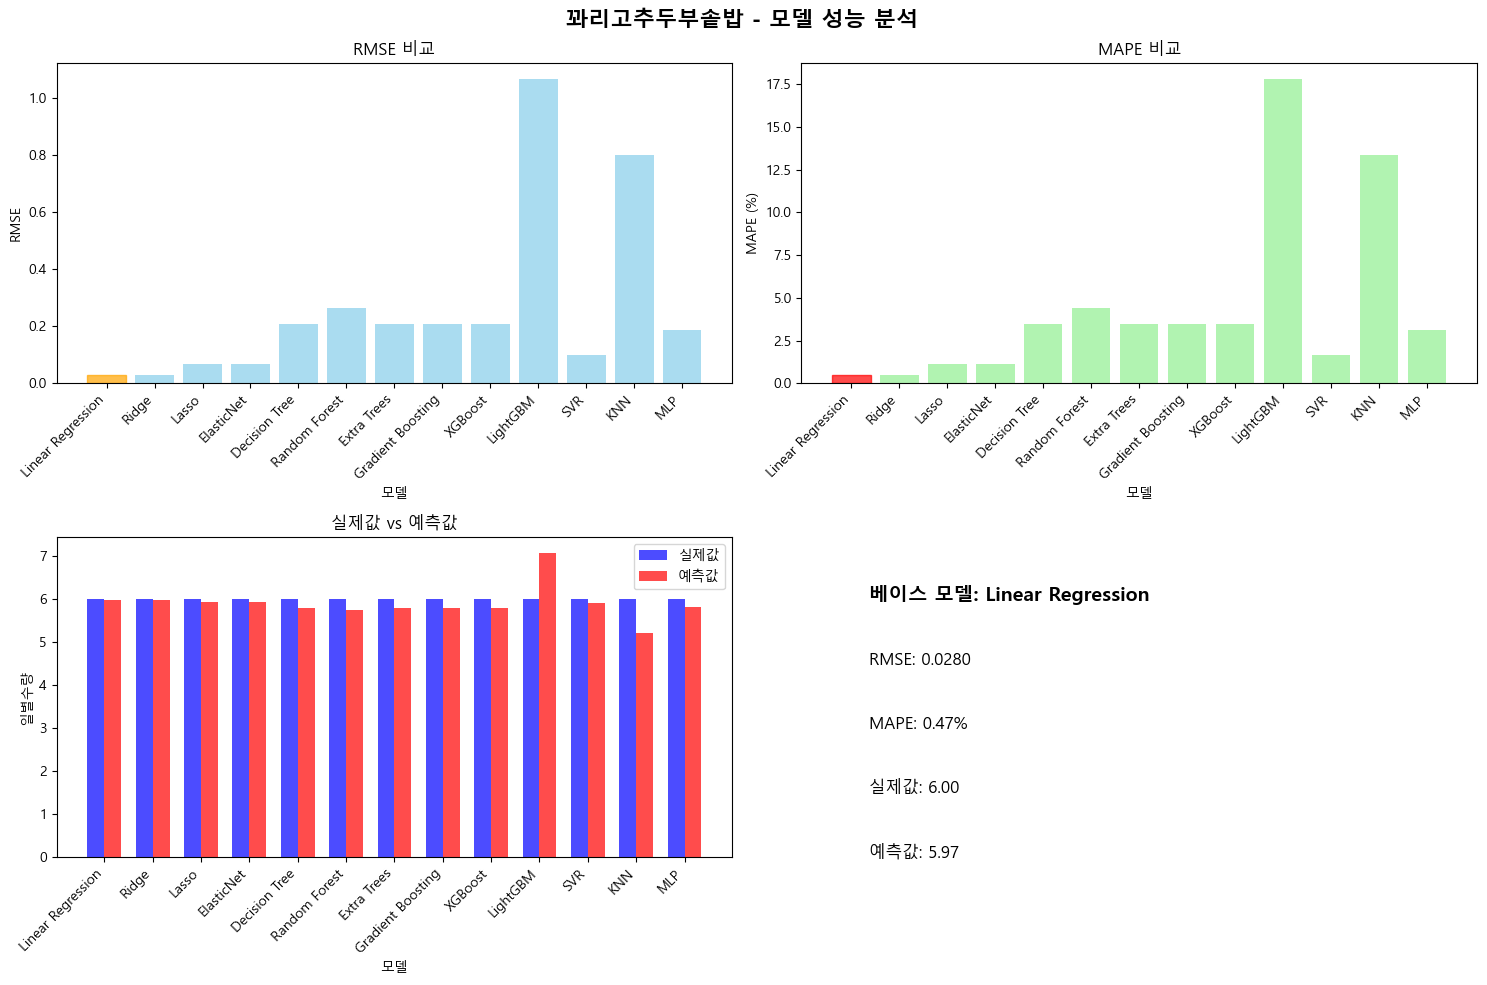

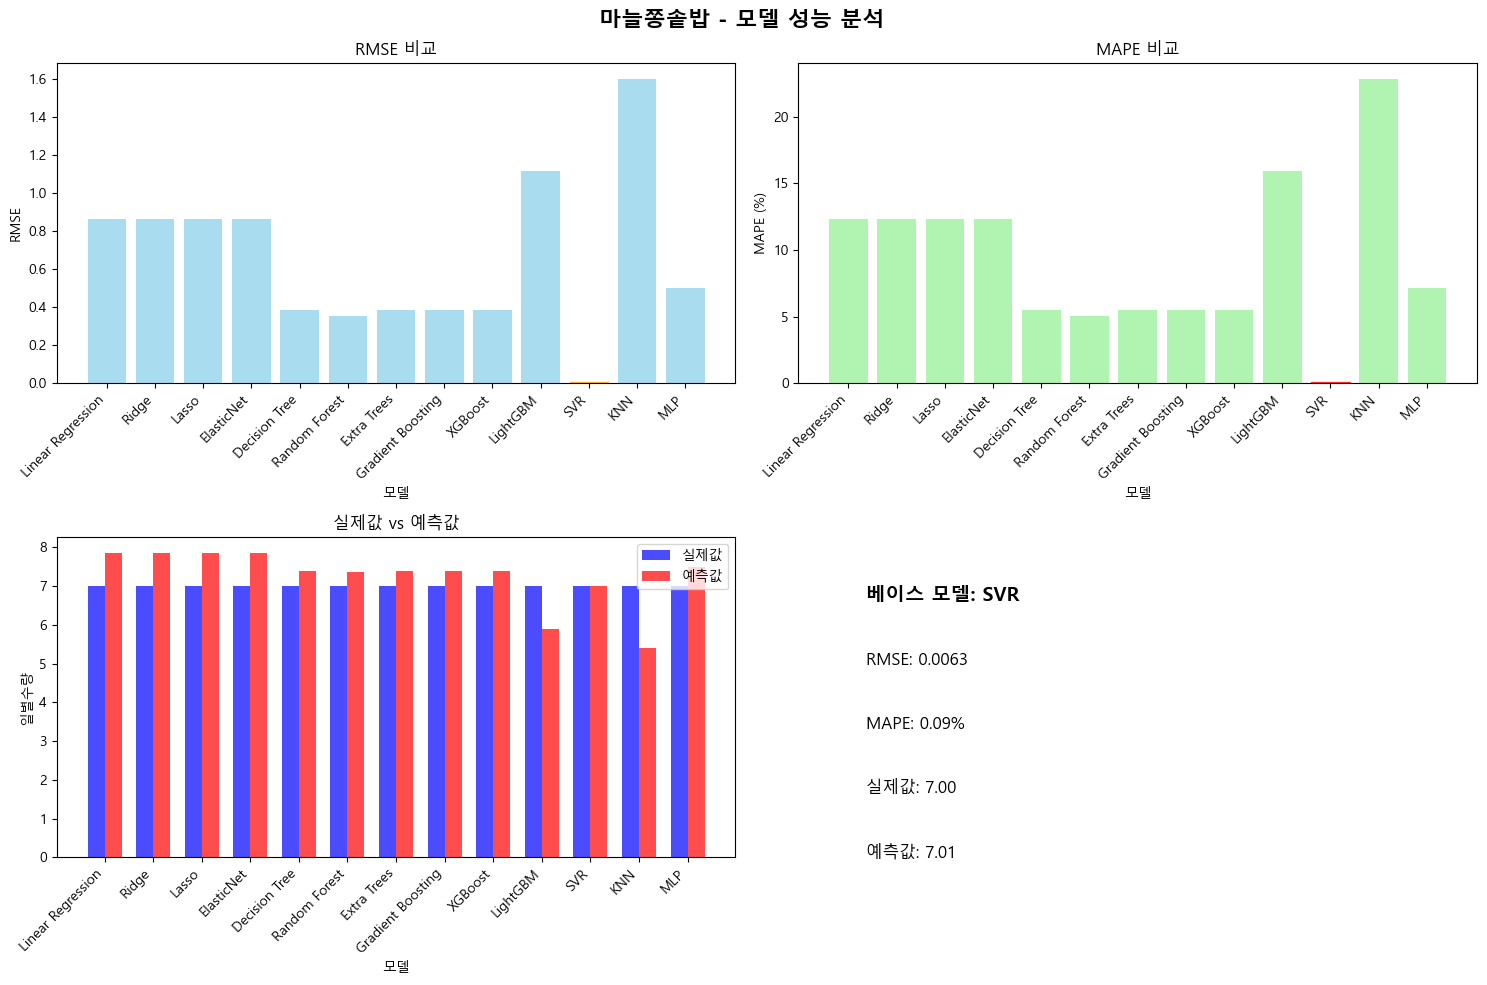

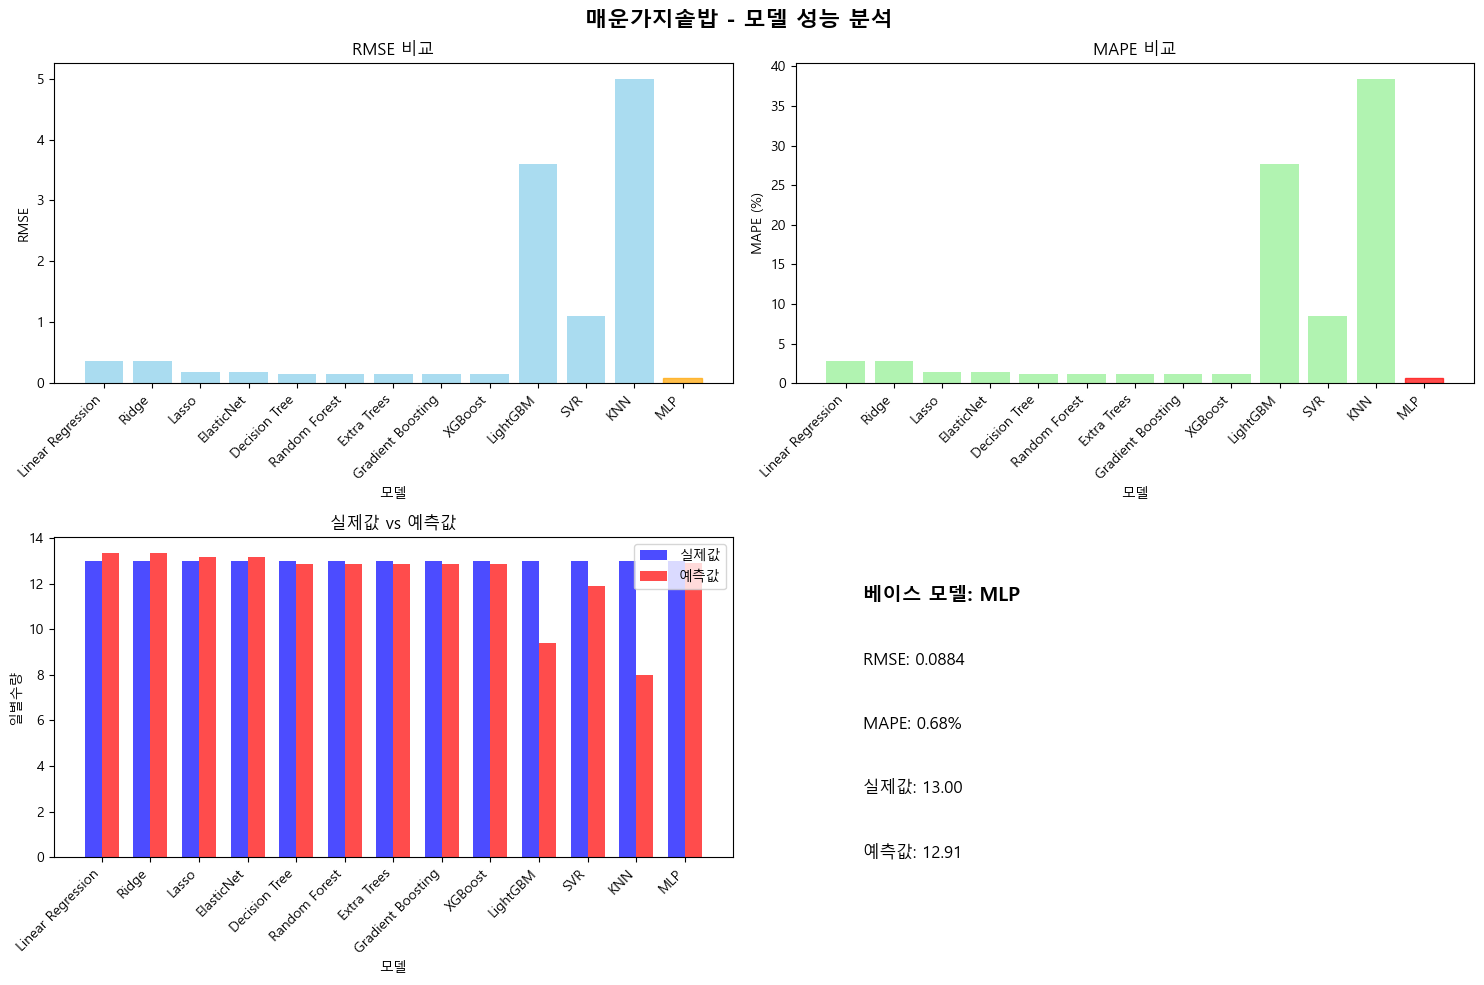

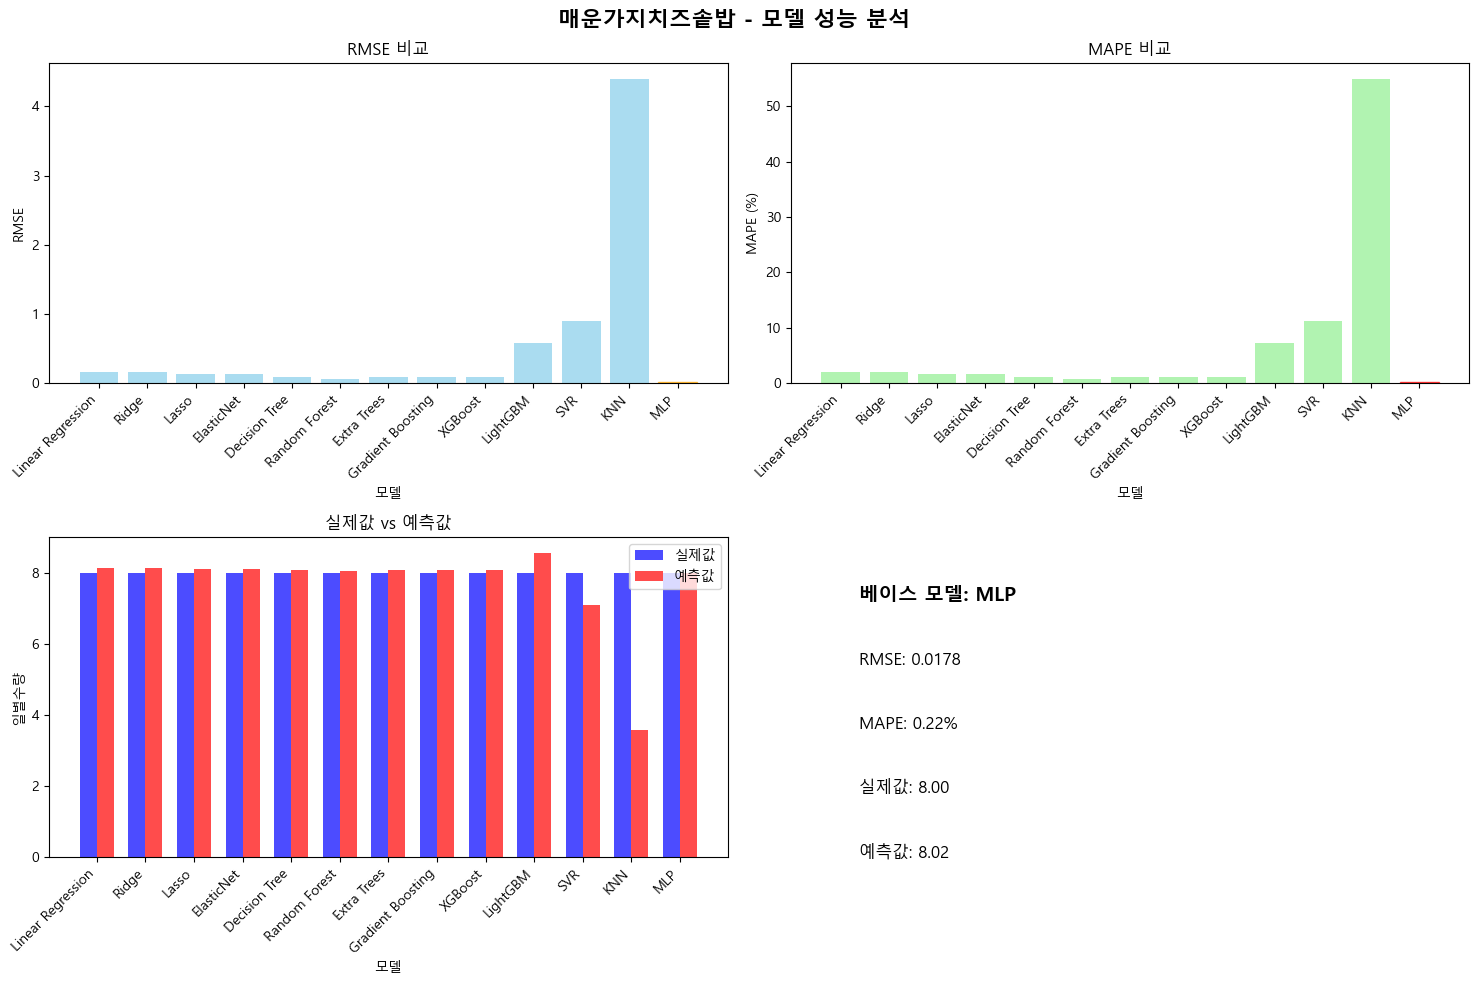

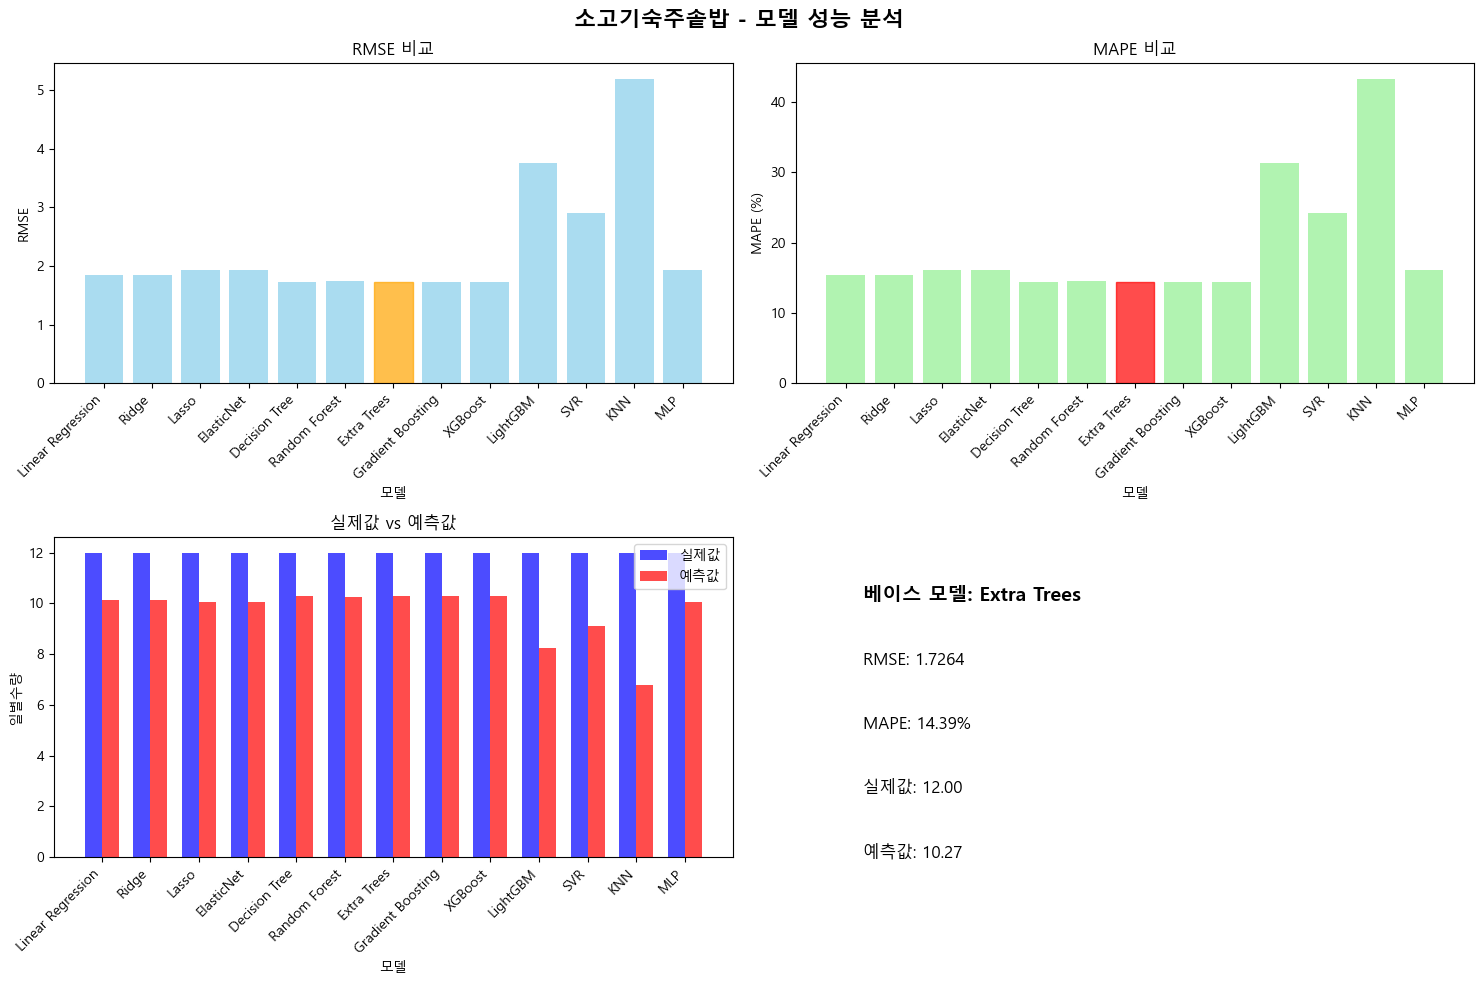

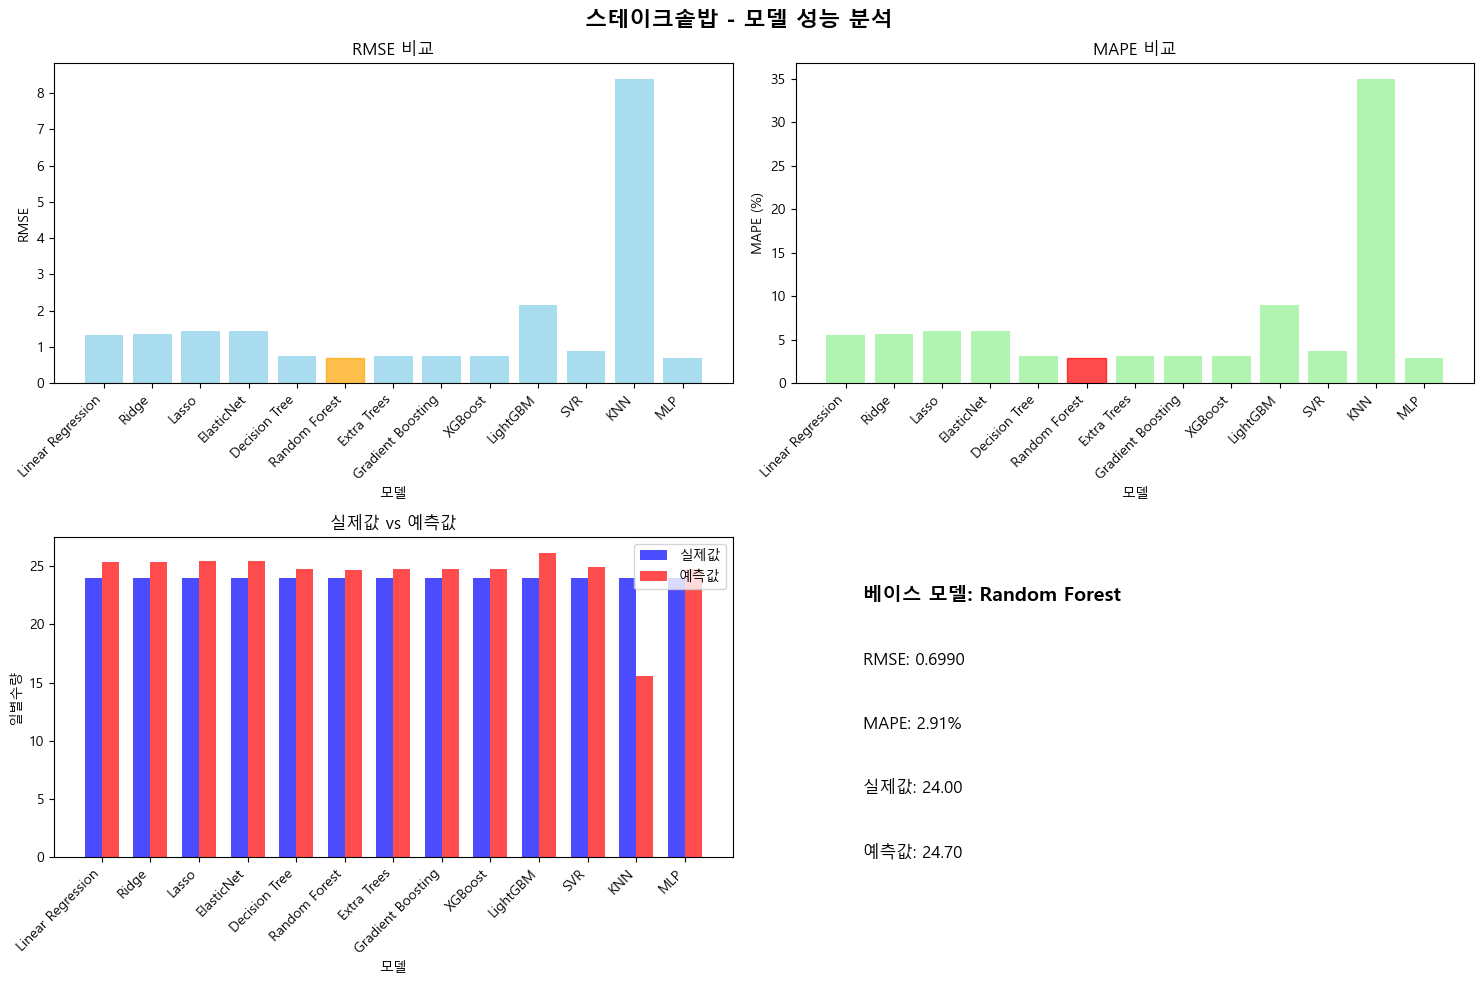

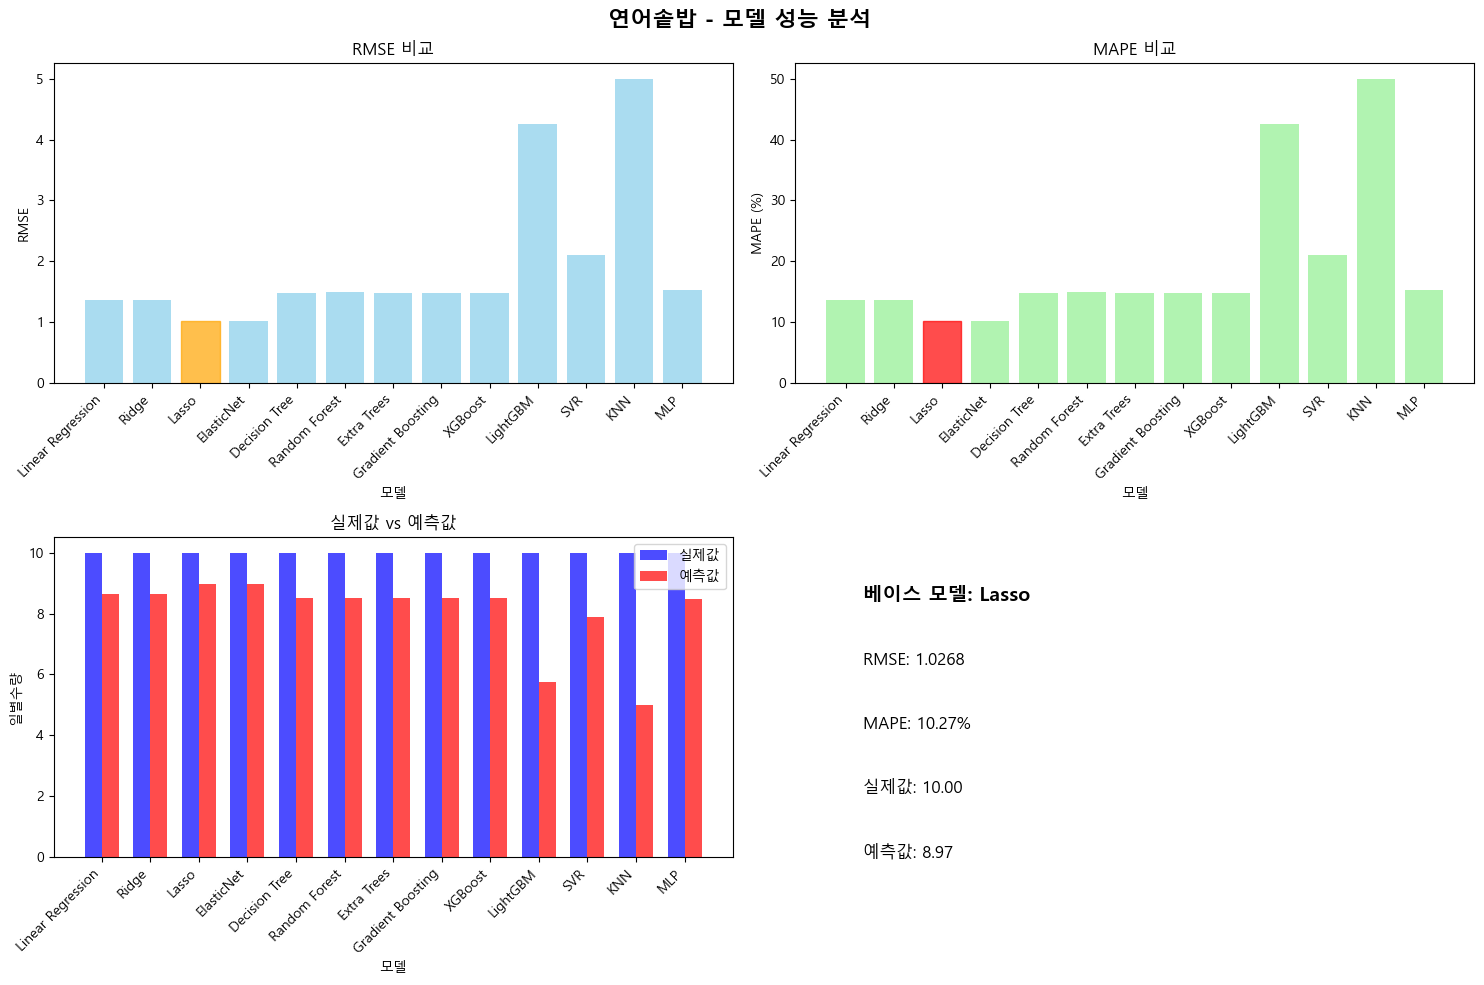

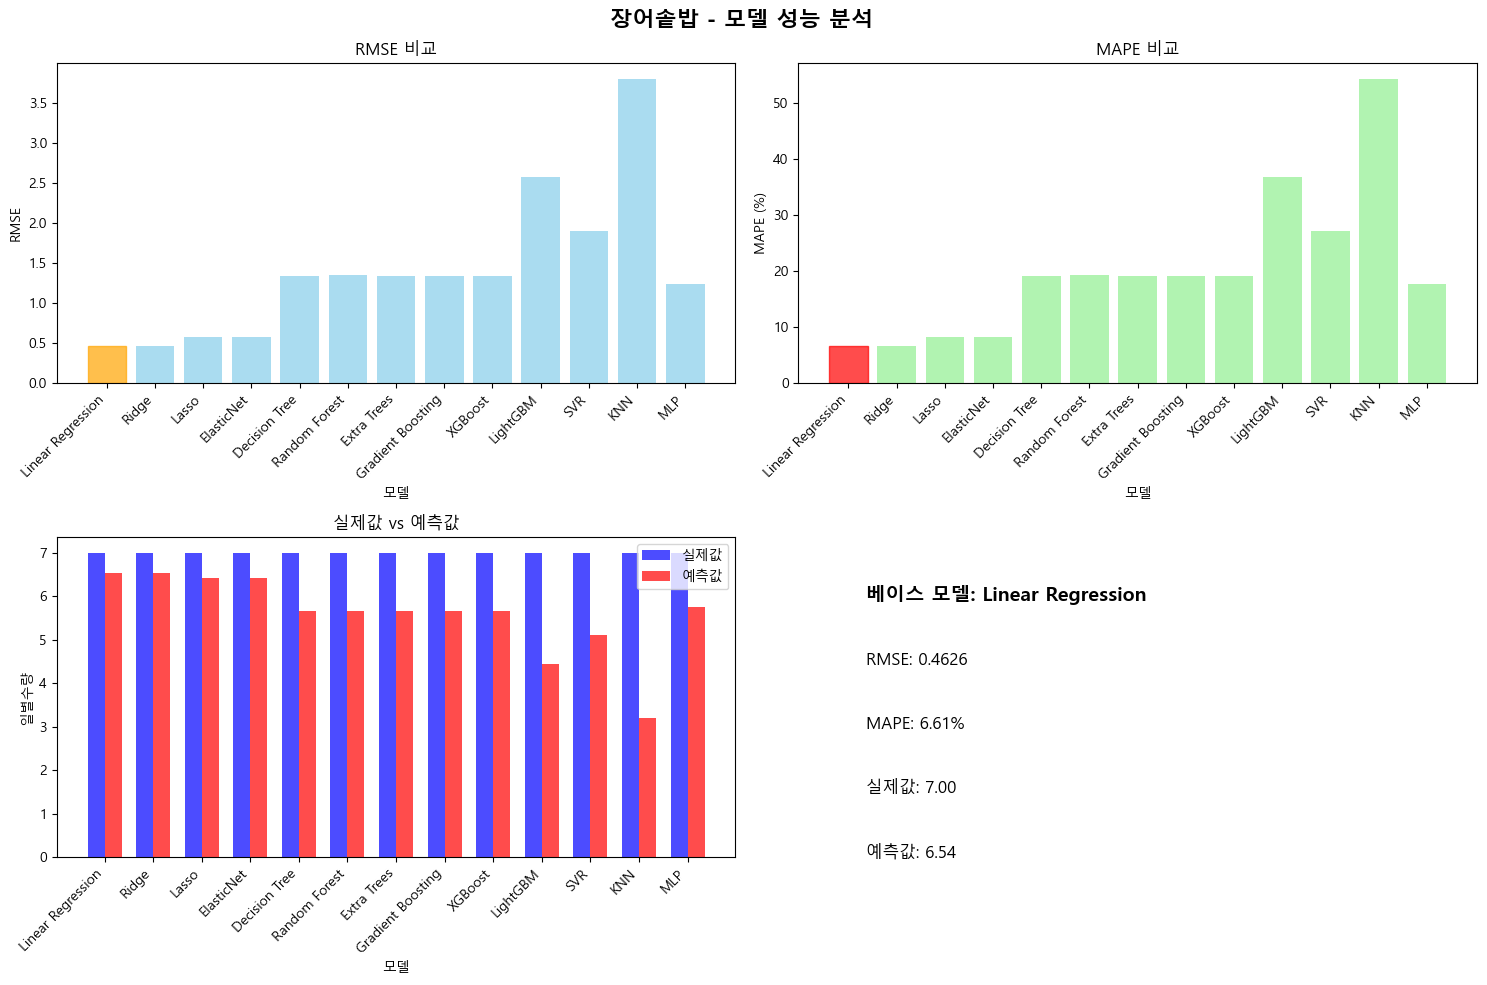

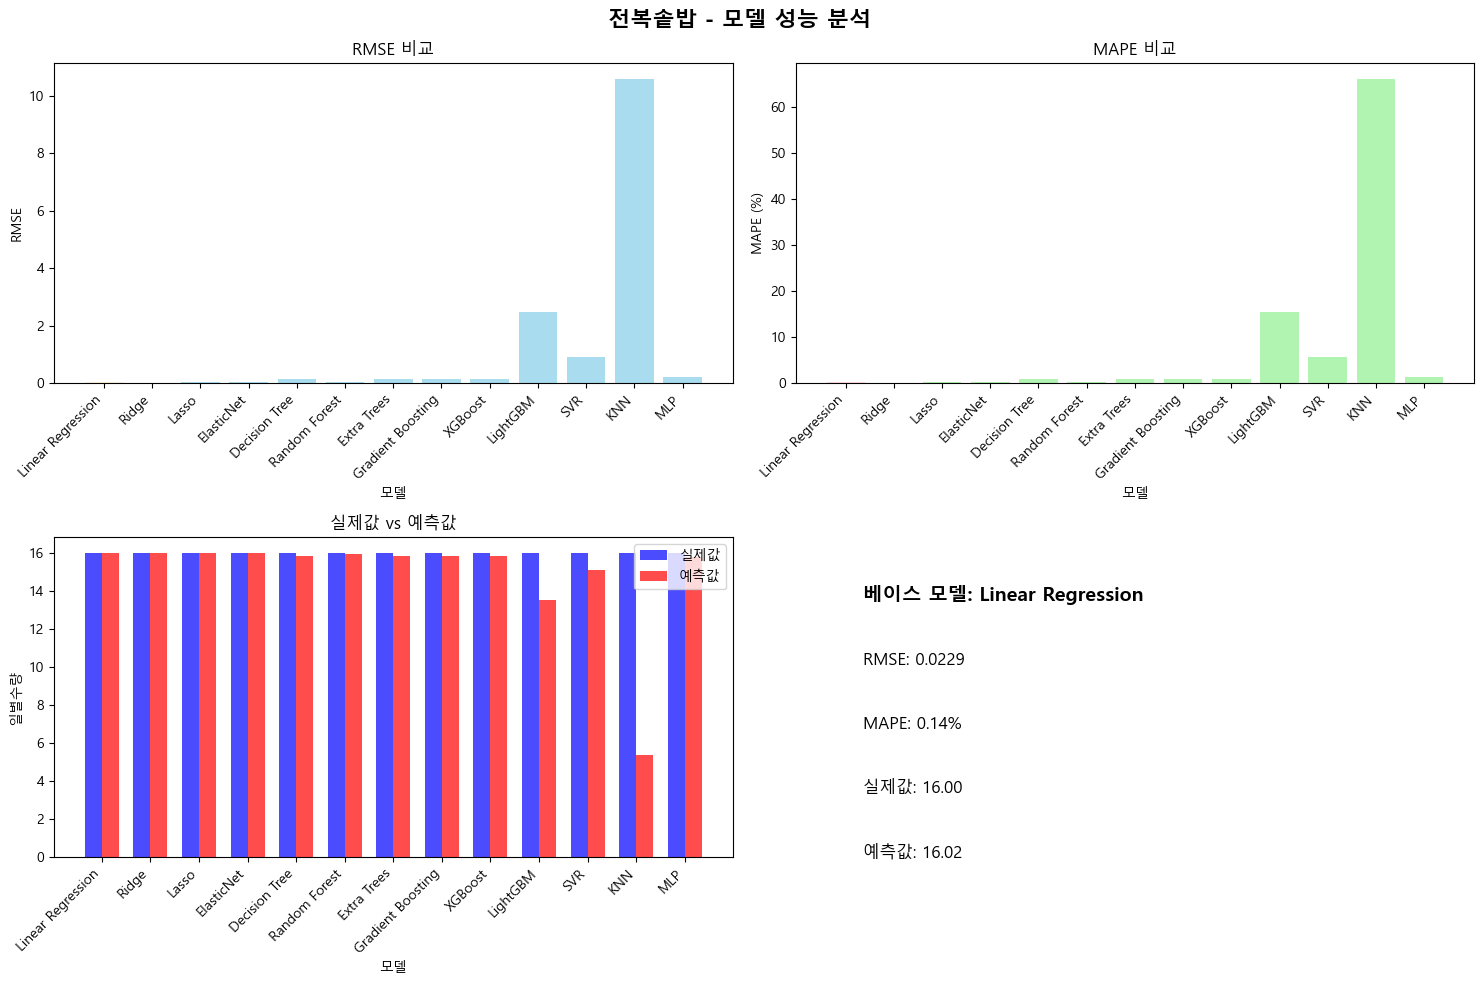


전체 결과 요약
      메뉴            베이스_모델   RMSE  MAPE(%)  실제값     예측값  오차율(%)
  가지치즈솥밥 Linear Regression 0.1820      inf    0  0.1820     inf
 우삼겹스키야키 Linear Regression 2.5933      inf    0  2.5933     inf
   우삼겹솥밥          LightGBM 7.1437  23.8123   30 22.8563 23.8123
   고등어솥밥          LightGBM 0.5468   6.0756    9  9.5468  6.0756
    가지솥밥          LightGBM 0.4926   2.4628   20 19.5074  2.4628
꽈리고추두부솥밥 Linear Regression 0.0280   0.4663    6  5.9720  0.4663
   마늘쫑솥밥               SVR 0.0063   0.0906    7  7.0063  0.0906
  매운가지솥밥               MLP 0.0884   0.6803   13 12.9116  0.6803
매운가지치즈솥밥               MLP 0.0178   0.2219    8  8.0178  0.2219
 소고기숙주솥밥       Extra Trees 1.7264  14.3868   12 10.2736 14.3868
  스테이크솥밥     Random Forest 0.6990   2.9124   24 24.6990  2.9124
    연어솥밥             Lasso 1.0268  10.2681   10  8.9732 10.2681
    장어솥밥 Linear Regression 0.4626   6.6086    7  6.5374  6.6086
    전복솥밥 Linear Regression 0.0229   0.1430   16 16.0229  0.1430

평균 RMSE: 1.0740
평균 MAPE: inf%

In [10]:
# 메인 실행 함수
def main():
    """
    전체 분석 파이프라인 실행
    """
    print("음식점 매출 예측 베이스 모델 구축을 시작합니다!")
    
    # 1. 데이터 로드
    df = load_from_gsheet()
    
    # 2. 모델 학습 및 평가
    results, menu_models = train_and_evaluate_models(df)
    
    # 3. 결과 시각화
    visualize_results(results)
    
    # 4. 결과 요약
    summary_results(results)
    
    return results, menu_models

# 사용 예시
if __name__ == "__main__":
    # 분석 실행
    results, models = main()
    
    print("\n분석이 완료되었습니다!")
    print("각 메뉴별 베스트 모델이 선정되었으며, 결과가 시각화되었습니다.")